# Granger

> Fill in a module description here

In [ ]:
#| default_exp granger

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
# NOTE: needed for python 3.10 forward compatibility with scanpy as 
# scanpy uses Iterable which is deprecated in 3.10
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

In [ ]:
#| export
import pandas as pd, numpy as np
import importlib, matplotlib as mpl, matplotlib.pyplot as plt, seaborn as sns

from joblib import Parallel, delayed
from typing import TypeAlias, List, Sequence, Tuple, Union, Optional
from degex.types import SeriesLike
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import grangercausalitytests

genes = 'wasf colq gpr1 chrm3 lmod2 tek kank3 oca2 taz map4k1'.split()
df_trj = pd.DataFrame(
    [
        np.sort(np.random.randint(0, 10, (100)))[::-1] if i % 2 == 0 else np.sort(np.random.randint(0, 10, (100)))
        for i in range(len(genes))
    ], index=genes
)
df_trj.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
wasf,9,9,9,9,9,9,9,9,9,9,...,0,0,0,0,0,0,0,0,0,0
colq,0,0,0,0,0,0,0,0,0,0,...,8,8,9,9,9,9,9,9,9,9
gpr1,9,9,9,9,9,9,9,9,8,8,...,0,0,0,0,0,0,0,0,0,0
chrm3,0,0,0,0,0,0,0,0,0,0,...,9,9,9,9,9,9,9,9,9,9
lmod2,9,9,9,9,9,9,9,9,9,8,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#| export
def confirm_trajectories_shape(trajectories:np.ndarray, verbose:bool=False) -> None:
    '''
    Confirms that the trajectory matrix has three axes and informs user of assumed shape.
    '''
    _CELLS = 'cells'
    _GENES = 'genes'
    _TBINS = 'timebins'    
    _TUPLE = (_TBINS, _CELLS, _GENES)

    shape = list(trajectories.shape)
    if len(shape) != 3:
        raise ValueError(f'Expected trajectory matrix with 3 axes, but trajectories has shape {shape}.')
    
    shape_str = ', '.join(list(map(lambda e: f'{e[0]} {e[1]}', tuple(zip(shape, _TUPLE)))))
    shape_str = f'({shape_str})'
    sm, md, lg = np.array(shape)[np.argsort(shape)]
    if verbose:
        print(f'trajectories is assumed to have shape {shape_str}')

def trajectories_to_cells_x_timebins(
    trajectories:np.ndarray, agg_fn=np.mean, 
    confirm_shape:bool=False, verbose:bool=False
) -> np.ndarray:
    '''
    Transpose and aggregate trajectories matrix (timebinse, cells, gene)
    to produce (cells, timebins)
    ''' 
    if confirm_shape:
        confirm_trajectories_shape(trajectories, verbose)
    return agg_fn(np.transpose(trajectories, (1, 0, 2)), axis=2)

def trajectories_to_genes_x_timebins(
    trajectories:np.ndarray, agg_fn=np.mean,
    confirm_shape:bool=False, verbose:bool=False
) -> np.ndarray:
    '''
    Transpose and aggregate trajectories matrix (timebinse, cells, gene)
    to produce (genes, timebins)
    '''
    if confirm_shape:
        confirm_trajectories_shape(trajectories, verbose)
    return agg_fn(np.transpose(trajectories, (2, 0, 1)), axis=2)

def kpss_test(series, print=False, **kwargs) -> None:
    # KPSS Null hypothesis: there is a no unit root, meaning series is stationary
    statistic, p_value, n_lags, critical_values = kpss(series, **kwargs)

    # Format Output    
    result_str = ''
    result_str += f'KPSS Statistic: {statistic}\n'
    result_str += f'p-value: {p_value}\n'
    result_str += f'num lags: {n_lags}\n'
    result_str += f'Critial Values:\n'    
    for key, value in critical_values.items():
        result_str += f'\t{key}:{value}\n'
    result_str += f'Result: The series is {"not " if p_value < 0.05 else ""}stationary'

    if print:
        print(result_str)
    return

def _add_suffix(arr, suffix:str):
    return list(map(lambda e: f'{e}_{suffix}', arr))

def _prep_args_for_granger_causality_tests(
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None,  
):
    '''
    Parameters
    ----------
    test : str, default='ssr_chi2test'
        the kind of statistical test to use
    
    lag_order : int, default=1
        how long to lag
    
    max_lag : tuple, optional
        if `None` coerced to `(1, )`
    
    Returns
    -------
    test : str
        `'ssr_chi2test'` if `test` was `None`
        
    lag_order : int
        `1` if `lag_order` was `None`

    max_lag : tuple
        `(1, )` if `max_lag` was `None`

    Notes
    -----
    lag_order
        `lag_order = 1` # becuase we got this value before. We are not suppose to add 1 to it
    
    max_lag
        `max_lag = (lag_order, )`
    '''
    if test is None:
        test = 'ssr_chi2test'

    if lag_order is None:
        lag_order = 1

    if max_lag is None:
        max_lag = (lag_order,)
    
    return test, lag_order, max_lag


def _ensure_no_constant_columns(
    df:pd.DataFrame, 
    copy:bool=True
) -> pd.DataFrame:
    '''
    Granger's Causality test fails if there is a constant in a column so we
    add small random noise to prevent this. 

    Parameters
    ----------
    df : pd.DataFrame
        Pandas DataFrame where rows are the response variable (genes), and 
        columns are predictors (expression).

    copy : bool, default=True
        Whether or not to copy input `df`

    Returns
    -------
    df : pd.DataFrame
        df (copy or modified in place) with small random noise added.
    '''
    _SAFETY = 1e-8
    rng_mat = np.random.randn(*df.shape) * _SAFETY    
    
    # NOTE: to ensure that no column in df is constant
    df_safe = (df.copy() if copy else df) + rng_mat
    return df_safe
    

def _prep_vars_for_granger_causality_tests(
    df:pd.DataFrame, 
    x_vars:SeriesLike=None, 
    y_vars:SeriesLike=None,
    do_safety_check:bool=True     
):
    '''
    Ensures `df` is safe for Granger Causality tests and that 
    `x_vars` and `y_vars` are not `None`.

    Parameters
    ----------
    df : pd.DataFrame
        Pandas DataFrame where rows are the response variable (genes), and 
        columns are predictors (expression).
    
    x_vars : SeriesLike, optional
        A subset of response variable (genes) to compute granger's causality test with. 
        If not provided, defaults to `df.index.values` i.e. all rows in `df`.


    y_vars : SeriesLike, optional
        A subset of response variable (genes) to compute granger's causality test with. 
        If not provided, defaults to `df.index.values` i.e. all rows in `df`.

    do_safety_check : bool, default=True
        Whether or not to check if there is a constant column in `df`.

        
    Returns
    -------
    df : pd.DataFrame
        input `df` possibly with small random noise added to prevent constant columns

    x_vars : SeriesLike
        input `x_vars` or `df.index.values` if `x_vars` was `None`

    y_vars : SeriesLike
        input `y_vars` or `df.index.values` if `y_vars` was `None`

    Notes
    -----
    If `x_var = ['A', B']` and `y_var = ['C', 'D]', then when calling Granger's 
    Causality the matrix returned has shape:
    ```
        | C | D |
        ---------
    | A |   |   |
    -------------
    | B |   |   |

    ```
    '''
    if do_safety_check:
        df = _ensure_no_constant_columns(df, copy=False)

    if x_vars is None:
        x_vars = df.index.values

    if y_vars is None:
        y_vars = df.index.values
    
    return df, x_vars, y_vars
    

def shift_trajectories(df:pd.DataFrame, shift:int=10, copy:bool=True) -> pd.DataFrame:
    '''
    Parameters
    ----------
    df : pd.DataFrame
        Pandas DataFrame where rows are the response variable (genes), and 
        columns are predictors (expression).
    
    shift : int, default=10
        number to shift `df`'s values by

    copy : bool, default=True
        Whether or not to copy input `df`

    Returns
    -------
    df_trj : pd.DataFrame
        Pandas DataFrame of `df - df_shift`
    '''
    df_trj = (df.copy() if copy else df)
    df_trj = df_trj.T[::shift]
    df_trj = df_trj - df_trj.shift(1)
    df_trj = df_trj.dropna()
    return df_trj

def get_pval_from_granger_causality_tests(
    df:pd.DataFrame,
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None, 
) -> float:
    '''
    Parameters
    ----------
    df : pd.DataFrame
        Pandas DataFrame where rows are the response variable (genes), and 
        columns are predictors (expression).

    test : str, default='ssr_chi2test'
        the kind of statistical test to use
    
    lag_order : int, default=1
        how long to lag
    
    max_lag : tuple, optional
        if `None` coerced to `(1, )`

    Returns
    -------
    min_p_value : float
        minimum p-value of Granger Causality Tests

    '''
    test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)
    test_result = grangercausalitytests(df, maxlag=max_lag, verbose=False)
    p_values = [test_result[i][0][test][1] for i in max_lag]
    min_p_value = np.min(p_values)
    return min_p_value

def grangers_causation_matrix(
    df:pd.DataFrame, 
    x_vars:SeriesLike=None, 
    y_vars:SeriesLike=None, 
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None,    
    n_jobs:int=-1
) -> pd.DataFrame:
    '''
    Computes Granger Causality

    Parameters
    ----------
    df : pd.DataFrame
        Pandas DataFrame where rows are the response variable (genes), and 
        columns are predictors (expression).
    
    x_vars : SeriesLike, optional
        A subset of response variable (genes) to compute granger's causality test with. 
        If not provided, defaults to `df.index.values` i.e. all rows in `df`.

    y_vars : SeriesLike, optional
        A subset of response variable (genes) to compute granger's causality test with. 
        If not provided, defaults to `df.index.values` i.e. all rows in `df`.

    test : str, default='ssr_chi2test'
        the kind of statistical test to use
    
    lag_order : int, default=1
        how long to lag
    
    max_lag : tuple, optional
        if `None` coerced to `(1, )`

    n_jobs : int, default=-1
        number of cpu threads to use during calculation
        
    Returns
    -------
    df_res : pd.DataFrame    
        Pandas DataFrame with shape `(len(x_vars), len(y_vars))` containing the
        minimum p-value from Granger's Causation Tests

    Notes
    -----
    If `x_var = ['A', B']` and `y_var = ['C', 'D]', the Granger's Causality matrix we
    return has shape:
    ```
           | C_y | D_y |
           -------------
    | A_x |      |     |
    --------------------
    | B_x |      |     |

    ```
    '''
    
    df, x_vars, y_vars       = _prep_vars_for_granger_causality_tests(df, x_vars, y_vars)
    test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)

    delayed_funcs = [
        delayed(get_pval_from_granger_causality_tests)(
            df[[x_var, y_var]], test, lag_order, max_lag
        ) for y_var in y_vars for x_var in x_vars
    ]

    parallel_out = Parallel(n_jobs=n_jobs)(delayed_funcs)
    
    df_res = pd.DataFrame(
        np.array(parallel_out).reshape((len(x_vars), len(y_vars))),
        index=x_vars, columns=y_vars,        
    )
    df_res.index = _add_suffix(x_vars, 'x')
    df_res.columns = _add_suffix(y_vars, 'y')
    return df_res


def calculate_granger_causation(
    df:pd.DataFrame,    
    x_vars:SeriesLike=None, 
    y_vars:SeriesLike=None,
    shift:int=10,
    test:str='ssr_chi2test', 
    lag_order:int=1,
    max_lag:tuple=None,    
    n_jobs:int=-1
) -> pd.DataFrame:     
    '''
    Computes Granger Causality

    Parameters
    ----------
    df : pd.DataFrame
        Pandas DataFrame where rows are the response variable (genes), and 
        columns are predictors (expression).
    
    x_vars : SeriesLike, optional
        A subset of response variable (genes) to compute granger's causality test with. 
        If not provided, defaults to `df.index.values` i.e. all rows in `df`.


    y_vars : SeriesLike, optional
        A subset of response variable (genes) to compute granger's causality test with. 
        If not provided, defaults to `df.index.values` i.e. all rows in `df`.

    shift : int, default=10
        number to shift `df`'s values by

    test : str, default='ssr_chi2test'
        the kind of statistical test to use
    
    lag_order : int, default=1
        how long to lag
    
    max_lag : tuple, optional
        if `None` coerced to `(1, )`

    n_jobs : int, default=-1
        number of cpu threads to use during calculation
        
    Returns
    -------
    df_res : pd.DataFrame    
        Pandas DataFrame with shape `(len(x_vars), len(y_vars))` containing the
        minimum p-value from Granger's Causation Tests

    Notes
    -----
    If `x_var = ['A', B']` and `y_var = ['C', 'D]', the Granger's Causality matrix we
    return has shape:
    ```
           | C_y | D_y |
           -------------
    | A_x |      |     |
    --------------------
    | B_x |      |     |

    ```
    '''
    
    df, x_vars, y_vars       = _prep_vars_for_granger_causality_tests(df, x_vars, y_vars)    
    test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)
    
    df_trj = shift_trajectories(df, shift)
        
    df_res = grangers_causation_matrix(
        df_trj, x_vars=x_vars, y_vars=y_vars,
        test=test, lag_order=lag_order, max_lag=max_lag,
        n_jobs=n_jobs
    )

    return df_res

def apply_log2_fold(df_granger:pd.DataFrame):
    return -np.log2(df_granger + (2 ** -20))    

def apply_signed_correlation(df_tseries:pd.DataFrame, df_granger:pd.DataFrame) -> pd.DataFrame:
    _stability = 1e-8
    var_names = df_tseries.index.values
    signed = -np.sign(df_tseries.T.corr()) * np.log(df_granger.values + _stability)
    df_res = pd.DataFrame(signed, index=var_names, columns=var_names)
    return df_res

def apply_standard_scaler(df:pd.DataFrame, return_scaler:bool=False) -> pd.DataFrame:
    scaler = StandardScaler()
    scaler = scaler.fit(df.T)
    df_res = pd.DataFrame(scaler.transform(df.T)).T
    df_res.index = df.index
    if return_scaler:
        df_res, scaler
    return df_res


In [ ]:
#| export

class GrangerCausality(BaseEstimator):
    def __init__(
        self, 
        x_vars:SeriesLike=None, 
        y_vars:SeriesLike=None,
        shift:int=10,
        test:str='ssr_chi2test', 
        lag_order:int=1,
        max_lag:tuple=None, 
        n_jobs:int=-1
    ):        
        '''
        Computes Granger Causality
        Check Granger Causality of all possible combinations of the Time series.

        The rows are the response variable, columns are predictors. The values in the table 
        are the P-Values. P-Values lesser than the significance level (0.05), implies 
        the Null Hypothesis that the coefficients of the corresponding past values is 
        zero, that is, the X does not cause Y can be rejected.

        Parameters
        ----------
        df : pd.DataFrame
            Pandas DataFrame where rows are the response variable (genes), and 
            columns are predictors (expression).
        
        x_vars : SeriesLike, optional
            A subset of response variable (genes) to compute granger's causality test with. 
            If not provided, defaults to `df.index.values` i.e. all rows in `df`.


        y_vars : SeriesLike, optional
            A subset of response variable (genes) to compute granger's causality test with. 
            If not provided, defaults to `df.index.values` i.e. all rows in `df`.

        shift : int, default=10
            number to shift `df`'s values by

        test : str, default='ssr_chi2test'
            the kind of statistical test to use
        
        lag_order : int, default=1
            how long to lag
        
        max_lag : tuple, optional
            if `None` coerced to `(1, )`

        n_jobs : int, default=-1
            number of cpu threads to use during calculation
            
        Returns
        -------
        df_res : pd.DataFrame    
            Pandas DataFrame with shape `(len(x_vars), len(y_vars))` containing the
            minimum p-value from Granger's Causation Tests

        Notes
        -----
        If `x_var = ['A', B']` and `y_var = ['C', 'D]', the Granger's Causality matrix we
        return has shape:
        ```
            | C_y | D_y |
            -------------
        | A_x |      |     |
        --------------------
        | B_x |      |     |

        ```

        See Also
        --------
        GrangerCausality._prep_args_for_granger_causality_tests :
            validates input arguments

        GrangerCausality._prep_vars_for_granger_causality_tests :
            validates input variables
        '''
    

        test, lag_order, max_lag = _prep_args_for_granger_causality_tests(test, lag_order, max_lag)

        self.x_vars = x_vars
        self.y_vars = y_vars
        self.shift = shift
        self.test = test
        self.max_lag = max_lag
        self.lag_order = lag_order
        self.n_jobs = n_jobs
        # original DataFrame
        self.df_org = None
        # results DataFrame
        self.df_res = None
        # scalar if transforming
        self.scaler = None


    def fit(self, X):
        '''
        Update internal parameters prior to computation in `transform`
        '''
        test, lag_order, max_lag = _prep_args_for_granger_causality_tests(self.test, self.lag_order, self.max_lag)
        X, x_vars, y_vars = _prep_vars_for_granger_causality_tests(X, self.x_vars, self.y_vars, do_safety_check=True)
        self.test = test
        self.lag_order = lag_order
        self.max_lag = max_lag
        self.x_vars = x_vars
        self.y_vars = y_vars
        return self
    
    def transform(self, X:pd.DataFrame, y=None, **fit_params):   
        # Save input DataFrame
        self.df_org = X.copy()

        _LOG2 = 'log2_fold'
        _SCOR = 'signed_correlation'
        _STDN = 'standard_scaler'
        if 'apply' in fit_params and fit_params['apply'] in [_LOG2, _SCOR, _STDN]:
            fit_params[fit_params['apply']] = True

        # Apply standard scaler
        if _STDN in fit_params and fit_params[_STDN]:
            self.apply_standard_scaler(X)

        # Use saved results
        if 'use_cached' in fit_params and fit_params['use_cached'] and self.df_res is not None:
            df_res = self.df_res.copy()
        else:
            df_res = calculate_granger_causation(
                X, x_vars=self.x_vars, y_vars=self.y_vars,
                shift=self.shift, test=self.test, 
                lag_order=self.lag_order, max_lag=self.max_lag,    
                n_jobs=self.n_jobs
            )

        # Store results
        self.df_res = df_res.copy()

        if _LOG2 in fit_params and fit_params[_LOG2]:
            df_res = apply_log2_fold(df_res)
        elif _SCOR in fit_params and fit_params[_SCOR]:
            df_res = apply_signed_correlation(X, df_res)        
        else:
            pass

        return df_res
    
    def fit_transform(self, X:pd.DataFrame, y=None, **fit_params):
        df_res = self.fit(X).transform(X, y=None, **fit_params)
        return df_res
    
    def apply_log2_fold(self, df:pd.DataFrame) -> pd.DataFrame:
        return apply_log2_fold(df)

    def apply_signed_correlation(self, df_tseries:pd.DataFrame, df_granger:pd.DataFrame) -> pd.DataFrame:
        return apply_signed_correlation(df_tseries, df_granger)
    
    def apply_standard_scaler(self, df:pd.DataFrame) -> pd.DataFrame:
        df_res, scaler = apply_standard_scaler(df, return_scaler=True)
        self.scaler = scaler
        return df_res
    
    def invert_scaler(self, df:pd.DataFrame) -> pd.DataFrame:
        if self.scaler is None:
            raise ValueError
        return self.scaler.inverse_transform(df)
    
    def plot_df_org(self, show_all_yticks:bool=True, **kwargs):
        '''
        Returns
        -------
        fig : matplotlib.pyplot.Figure
        ax : matplotlib.pyplot.Axis
        ClusterMap : seaborn.ClusterMap
        '''
        options = dict(cmap='inferno', robust=True, col_cluster=False, yticklabels=show_all_yticks)
        options.update(kwargs)
        cstrmp = sns.clustermap(self.df_org, **options)
        return cstrmp
    
    def plot_df_res(self, show_all_yticks:bool=True, **kwargs):
        '''
        Returns
        -------
        fig : matplotlib.pyplot.Figure
        ax : matplotlib.pyplot.Axis
        ClusterMap : seaborn.ClusterMap
        '''           
        options = dict(yticklabels=show_all_yticks)
        options.update(kwargs)
        cstrmp = sns.clustermap(self.df_res, **options)
        return cstrmp


In [ ]:
# gc_op = GrangerCausality(n_jobs=2)
# df_res = gc_op.fit_transform(df_trj, fit_params={'standard_scaler':True, 'signed_correlation': True})

<seaborn.matrix.ClusterGrid>

<Figure size 1200x800 with 0 Axes>

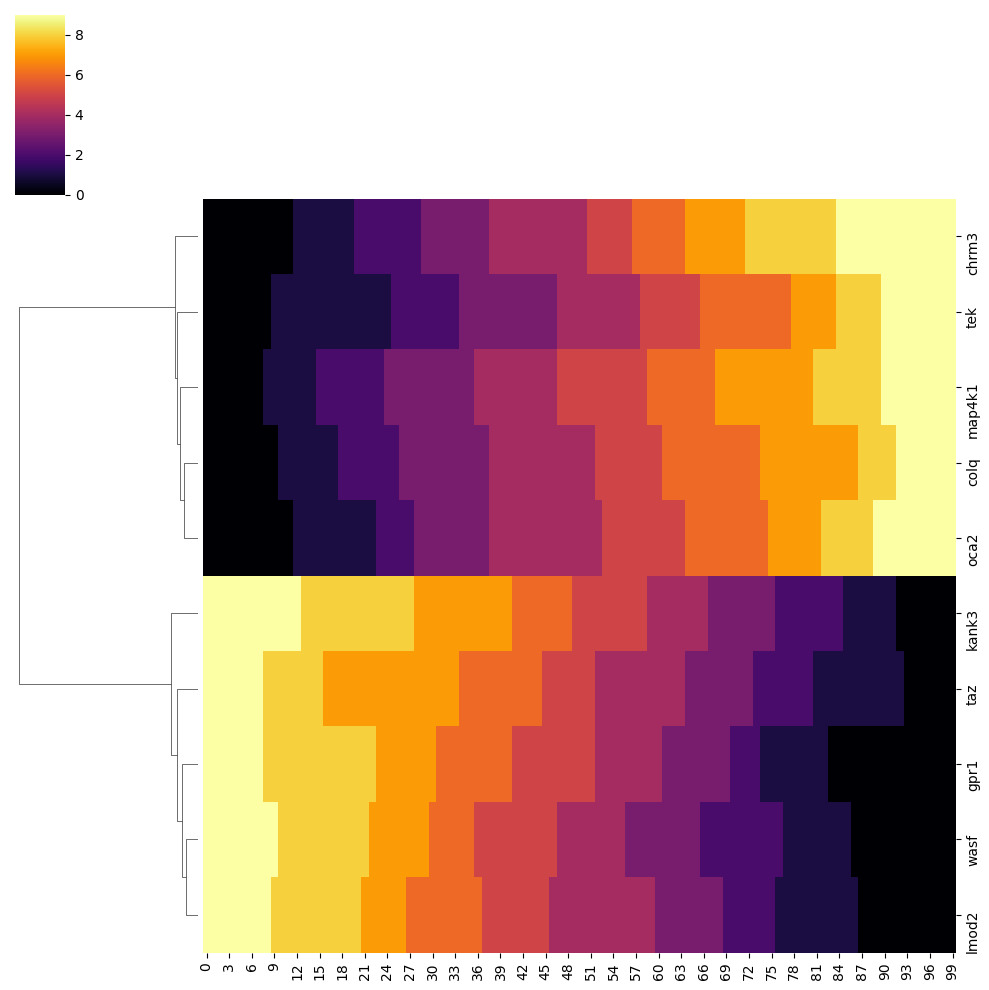

In [ ]:
# gc_op.plot_df_org()

<seaborn.matrix.ClusterGrid>

<Figure size 1200x800 with 0 Axes>

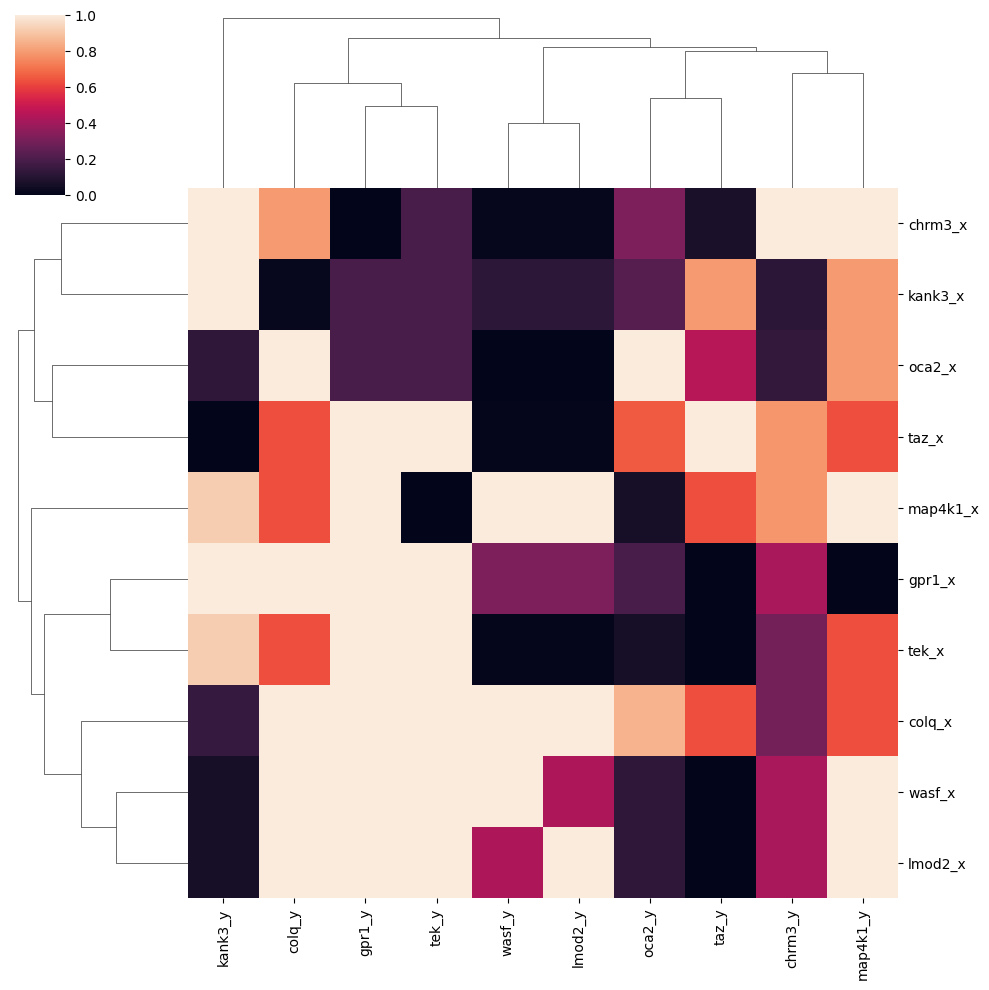

In [ ]:
# gc_op.plot_df_res()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()